Using the rectrangle-shaped fuzzy number set definition, we apply the ASHLO algorithm to optimize the interval of universe discourse and offsets at two ends dynamically as time moves forward. The fitness function is to minimize the final RMSE of test data set.

In [1]:
from rectangle_fuzzy import *

import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# helper functions
def binary_to_decimal(binary, di=0):
    decimal = 0
    for i in range(len(binary)):
        if i<len(binary)-di+1:
            power = len(binary)-(i+1)-di
            decimal += int(binary[i]) * (2**power)
        else:
            power = len(binary)-(i+1)-di
            decimal += int(binary[i]) * (2**(-power))
    return decimal

def universe_partition_adjusted(data, n=10, d1=10, d2=10):
    x_max, x_min = data.max(axis=0), data.min(axis=0)   
    delta = x_max - x_min
    std_val = data.std(axis=0)
    len_val = np.round(std_val / (n+5)) # partition interval
    u_max, u_min = int(x_max+(d2+1)*delta/100), int(x_min-(d1+1)*delta/100) # bound of universe discourse
    u_b = np.arange(u_min, u_max, step=float(len_val)) # cutting points
    u_discourse = u_b
    return u_discourse

def compute_fitness(data, n, d1, d2, option='Price'):
    valid_days = 200
    first_date = data['Date'][0] - pd.DateOffset(days=1)
    train_data = data.iloc[0:]
    valid_data = data.iloc[-(valid_days+1):]
    fit_prices = list()
    u_discourse = universe_partition_adjusted(train_data[option], n, d1, d2)
    A_list = set_fuzzy_numbers(u_discourse)
    train_data_membership_series = membership_assignment(train_data[option], fuzzy_numbers=u_discourse)
    transition_FLR = FLR(train_data_membership_series)
    train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist()
    jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    for price in valid_data.iloc[:-1][option]:
        index = get_membership(price, u_discourse)
        next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=0.9)
        fit_prices.append(next_price)
    return np.sqrt(mean_squared_error(valid_data.iloc[1:][option], fit_prices))

In [3]:
# Load data 
datafile = '../data/IBEX35.csv'
dateparse = lambda x: pd.datetime.strptime(x, '%m/%d/%y')
df = pd.read_csv(datafile, header=0, parse_dates=['Date'], date_parser=dateparse)

split_date = pd.datetime.strptime('2014-12-31', '%Y-%m-%d')
train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]
first_date = train_data['Date'][0] - pd.DateOffset(days=1)

option = 'Price'

In [4]:
# initialize the parameters of ASHLO algorithm
d1_digits = 4
n_digits = 6
d2_digits = 4
population = 200
iter_max = 1000
pr = 0.1
pi = 0.9

dim_IKD = d1_digits+n_digits+d2_digits
RMSE_list = list() # training data RMSE as fitness function value
IKD = np.zeros((population, dim_IKD), dtype=int) # individual learning 
SKD = np.array([]) # social network learning
RMSE_min = 0 # best fitness value

for i in range(population):
    for j in range(dim_IKD):
        r = np.random.rand()
        if r>0.5:
            IKD[i, j] = 0
        else:
            IKD[i, j] = 1
    d1 = binary_to_decimal(IKD[i, 0:d1_digits])
    d2 = binary_to_decimal(IKD[i, (d1_digits+n_digits): dim_IKD])
    n_par = binary_to_decimal(IKD[i, d1_digits:(d1_digits+n_digits)])
    rmse = compute_fitness(train_data, n_par, d1, d2)
    RMSE_list.append(rmse)
RMSE_min = np.min(RMSE_list)
SKD = np.array(IKD[np.argmin(RMSE_list)])

In [5]:
start_time = time()
for iter_count in range(iter_max):
    temp_IKD = np.zeros((population, dim_IKD))
    temp_rmse_list = list()
    # learning process
    for i in range(population):
        for j in range(dim_IKD):
            p = np.random.rand()
            if p < pi:
                r = np.random.rand()
                if r > 0.5:
                    temp_IKD[i, j] = 1
            elif pi <= p <= pr:
                temp_IKD[i,j] = IKD[i, j]
            else:
                temp_IKD[i,j] = SKD[j]
    # update fitness of newly learned knowledge 
    for i in range(population):
        d1 = binary_to_decimal(temp_IKD[i, 0:d1_digits])
        d2 = binary_to_decimal(temp_IKD[i, (d1_digits+n_digits): dim_IKD])
        n_par = binary_to_decimal(temp_IKD[i, d1_digits:(d1_digits+n_digits)])
        rmse = compute_fitness(train_data, n_par, d1, d2)
        temp_rmse_list.append(rmse)
        
    # update knowledge base if necessary
    RMSE_max = np.max(RMSE_list) # worst individual fitness
    RMSE_max_index = np.argmax(RMSE_list)
    for i in range(population):
        if temp_rmse_list[i] < RMSE_max:
            IKD[RMSE_max_index] = temp_IKD[i]
            RMSE_list[RMSE_max_index] = temp_rmse_list[i]
            RMSE_max = np.max(RMSE_list)
            RMSE_max_index = np.argmax(RMSE_list)
    temp_rmse_min = np.min(RMSE_list) # best individual fitness
    if RMSE_min > temp_rmse_min:
        SKD = np.array(IKD[np.argmin(RMSE_list)])
        RMSE_min = temp_rmse_min
print "Time cost: "+str(time()-start_time)+" seconds" 

Time cost: 14036.0491149 seconds


In [6]:
# forecasting using test data
start_time = time()
pred_prices = list()
actual_prices = test_data[option].tolist()[1:]
indices = test_data.index
d1 = binary_to_decimal(SKD[0:d1_digits])
d2 = binary_to_decimal(SKD[(d1_digits+n_digits): dim_IKD])
n_par = binary_to_decimal(SKD[d1_digits:(d1_digits+n_digits)])
print("\t\td1=%f, d2=%f, n=%f" % (d1, d2, n_par))
for i in range(len(indices)-1):
    prev = test_data.iloc[i]
    train_data.append(prev)
    u_discourse = universe_partition_adjusted(train_data[option], n_par, d1, d2)
    A_list = set_fuzzy_numbers(u_discourse)
    train_data_membership_series = membership_assignment(train_data[option], fuzzy_numbers=u_discourse)
    transition_FLR = FLR(train_data_membership_series)
    train_data_days = train_data['Date'].apply(lambda x: x-first_date).dt.days.tolist() # convert Timedelta to numeric days
    jump_weights = FLR_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    transition_weights = FRG_weight(transition_FLR, train_data_days[:len(transition_FLR)])
    price = prev[option]
    index = get_membership(price, u_discourse)
    next_price = forecast_price(forecast_jump(index, jump_weights, A_list), forecast_transition(index, transition_weights, A_list), gamma=0.9)
    pred_prices.append(next_price)
    
print "RMSE = "+str(np.sqrt(mean_squared_error(actual_prices, pred_prices)))
print "Time cost: "+str(time()-start_time)+" seconds" 

		d1=5.000000, d2=1.000000, n=20.000000
RMSE = 211.721590447
Time cost: 7.2945330143 seconds


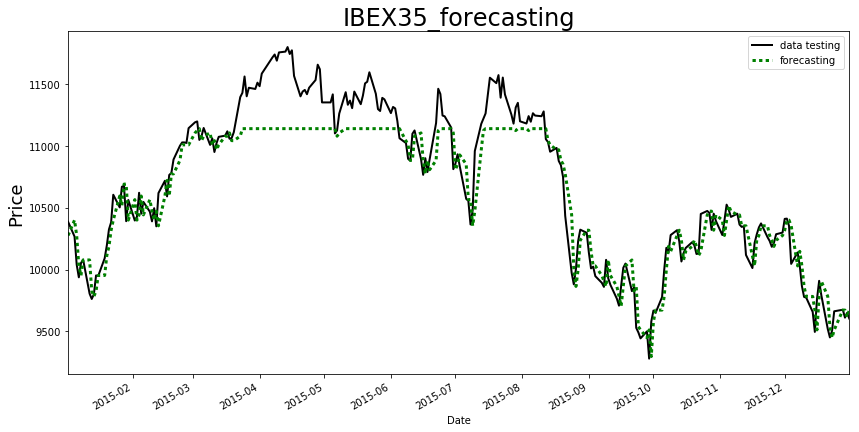

In [7]:
df_test = pd.DataFrame(test_data.iloc[1:]['Date'])
df_test['data testing'] = pd.Series(actual_prices).values
df_test['forecasting'] = pd.Series(pred_prices).values
df_test.index = df_test['Date']
plt.figure(figsize=(14,7))
df_test['data testing'].plot(style='k-', linewidth=2, label='data testing')
df_test['forecasting'].plot(style='g:', linewidth=3, label='forecasting')
plt.ylabel('Price', fontsize=18)
plt.legend(loc='best')
plt.title("IBEX35_forecasting", fontsize=24)